## Problem Set 2 (MACSS 30200)
## Kevin Sun
## April 30, 2018

### Question 1 - Kernel Density Estimator

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

In [2]:
print(bq_data.shape) # get shape of Numpy Array
print(bq_data.sum(axis=0)) # distribution of inheritance by income group
print(bq_data.sum()) # sum all probabilities

(78, 7)
[ 0.01214584  0.00817072  0.01590964  0.0139963   0.01383075  0.06927237
  0.86667437]
1.0


### 1a) Plotting the 3D Surface Plot

<IPython.core.display.Javascript object>


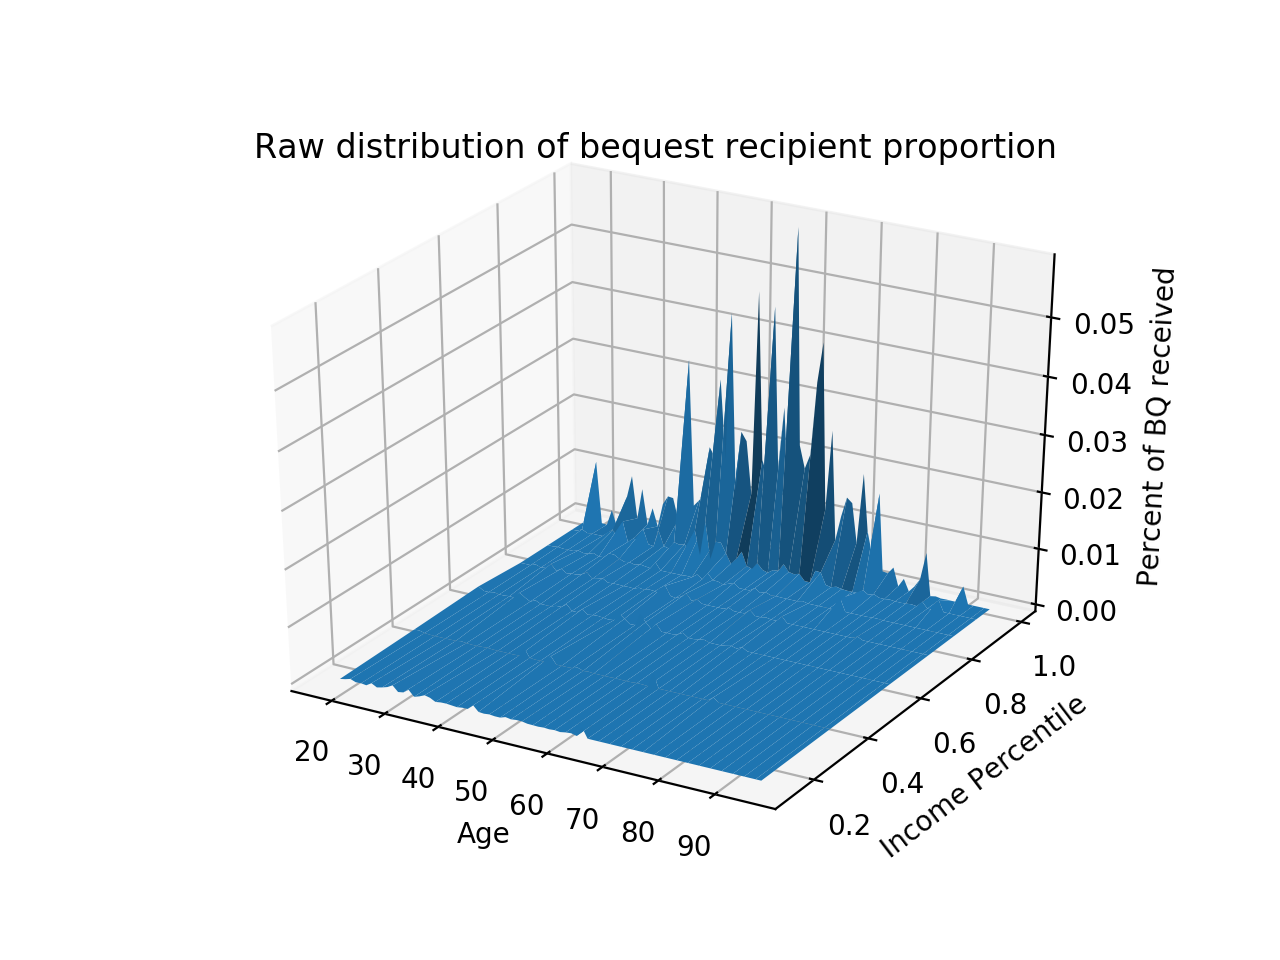

In [3]:
age_vec = np.arange(18, 96)
#prcntl = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
prcntl_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_matrix, age_matrix = np.meshgrid(prcntl_mdpts, age_vec)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_matrix, income_matrix, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Percentile')
ax.set_zlabel('Percent of BQ received');

### 1b) Plotting a bivariate kernel density estimator

In [4]:
from scipy.stats import gaussian_kde
np.random.seed(88)

In [5]:
age_vec = np.arange(18, 96)
prcntl_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])

# get proportions of each income and age group 
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)

# set some large sample
lrg_samp = 70000

# get random distributions out of 70000 sample, based on age and income proportions/probabilities
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
print(age_probs)
print("age_probs shape:", age_probs.shape)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
print(income_probs)
print("income_probs shape:", income_probs.shape)

[  66   39  910   41   15  233  151   71  672  867  529  640  281  595  367
  536  658  911  325  342 2507  823  716  720 1654 1309 2805 1326 3411 1080
 1729 1790 1090 3557 1342 1091 3331 1293 1934  883 4257 1683 1457 1590 2515
 3153  788 2005  662  772 1107  992  465 1435  606  334 1502  193  180  260
   27  163   11   90  195  492    0   78    0    4  130    0  214    0    0
    0    0    0]
age_probs shape: (78,)
[  785   581  1120   974   952  4880 60708]
income_probs shape: (7,)


In [6]:
# create two empty numpy arrays
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num in zip(age_vec, age_probs):
    #print(age, num)
    vec_age = np.ones(num) # create vector of 1's that is length of num
    vec_age *= age # multiply each 1 by the age -> fills age vector
    #print(age_freq, vec_age)
    age_freq = np.append(age_freq, vec_age) #fill each vector with counts

# creating a distribution of ability type values
for inc, num_j in zip(prcntl_mdpts, income_probs):
    vec_income = np.ones(num_j)
    vec_income *= inc
    inc_freq = np.append(inc_freq, vec_income)
    
data = np.vstack((age_freq, inc_freq))

In [7]:
# justifying the choice of lambda
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data);

/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
grid.best_params_

{'bandwidth': 0.10000000000000001}

In [9]:
bandwidth = 0.1 #see above for justification
kernel_object = gaussian_kde(data, bw_method=bandwidth)
coords = np.vstack([item.ravel() for item in [age_matrix, income_matrix]])
Z = kernel_object(coords).reshape(age_matrix.shape)
Z_scaled = Z / float(np.sum(Z))

<IPython.core.display.Javascript object>


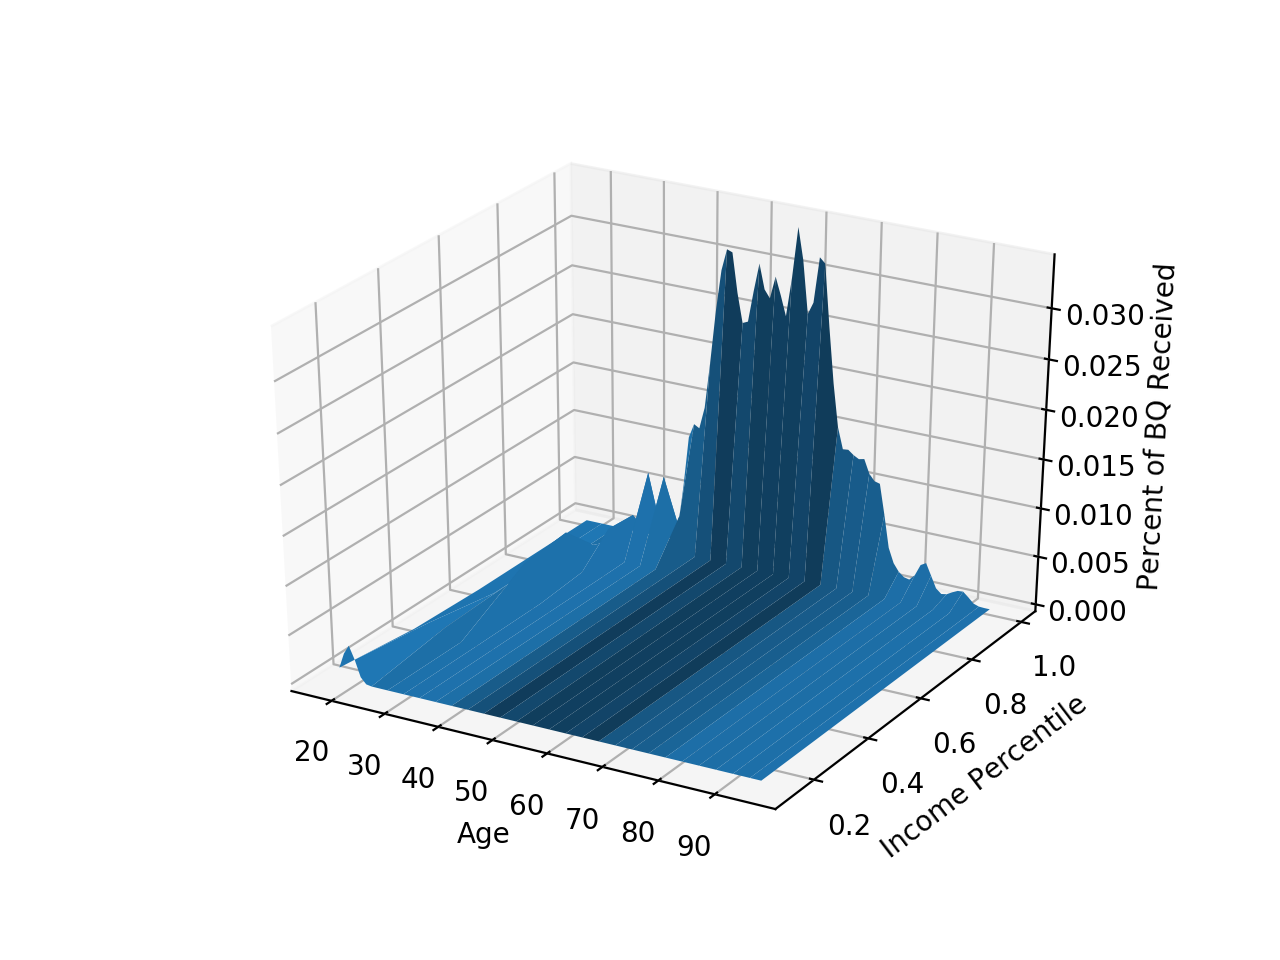

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_matrix, income_matrix, Z_scaled, rstride=3)
ax.set_xlabel("Age")
ax.set_ylabel("Income Percentile")
ax.set_zlabel("Percent of BQ Received");

In [11]:
est_density = Z_scaled[61-18+1,5]
print("The estimated density for a person aged 61 who lies between the 90th and 99th percentile is:", est_density)

The estimated density for a person aged 61 who lies between the 90th and 99th percentile is: 5.90697866444e-07


### Question 2 - Interaction Terms

In [12]:
import pandas as pd
biden = pd.read_csv('biden.csv', usecols=['biden', 'age', 'educ'])

In [13]:
biden.head()

,biden,age,educ
0,90.0,19.0,12.0
1,70.0,51.0,14.0
2,60.0,27.0,14.0
3,50.0,43.0,14.0
4,60.0,38.0,14.0


In [14]:
import statsmodels.api as sm
biden.dropna(inplace=True)
y = biden['biden'] # define y variable
biden['age_educ'] = biden['age'] * biden['educ'] # create interaction term
biden['constant'] = 1
X = biden[['constant','age', 'educ', 'age_educ']] # define x variables

/Users/kevinsun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        08:07:08   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      37.5491      9.491      3.956      0.000      18.935      56.163
age            0.6674      0.169      3.950      0.000       0.336       0.999
educ           1.7123      0.709      2.414      0.016       0.321       3.103
age_educ      -0.0477      0.013     -3.728      0.000      -0.073      -0.023
==============================================================================
Omnibus:                       64.792   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.979
Skew:                          -0.480   Prob(JB):                     3.86e-16
Kurtosis:                       3.105   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Each of the coefficients, including the interaction term, are statistically significant. Taking the above table as is, the marginal effect of AGE on Biden sentiment is 0.6674 - 0.0477$\sf{x_{3}}$. This means that if EDUC is 0 than the marginal effect of AGE on Biden sentiment is 0.6674. However, if a person has more education, than the relative positive impact of their age decreases given the negative coeffecient on the interaction term. Conversely the marginal effect of EDUC on Biden sentiment is 1.7123 - 0.0477$\sf{x_{3}}$. This means that if AGE is 0 than the marginal effect of EDUC on Biden sentiment is 1.7123. However, if a person ages, than the relative positive impact of their education decreases given the negative coefficient on the interaction term.

In [34]:
# Extract beta coefficients:
b_1 = results.params["age"]
b_2 = results.params["educ"]
b_3 = results.params["age_educ"]
# Get variance-covariance matrix:
var_covar_mat = results.cov_params()
print("Variance-Covariance Matrix:")
print(var_covar_mat)

Variance-Covariance Matrix:
           constant       age      educ  age_educ
constant  90.077473 -1.520617 -6.629478  0.112692
age       -1.520617  0.028545  0.112425 -0.002122
educ      -6.629478  0.112425  0.502923 -0.008616
age_educ   0.112692 -0.002122 -0.008616  0.000164


In [24]:
point_min = 0.6674 - biden["educ"].min() * 0.0477

SE_min = np.sqrt(var_covar_mat["age"]["age"] + 
                       biden["educ"].min() ** 2 * 
                       var_covar_mat["age_educ"]["age_educ"] + 
                       2 * biden["educ"].min() * var_covar_mat["age"]["age_educ"])

point_max = 0.6674 - biden["educ"].max() * 0.0477

SE_max = np.sqrt(var_covar_mat["age"]["age"] + 
                       biden["educ"].max() ** 2 * 
                       var_covar_mat["age_educ"]["age_educ"] + 
                       2 * biden["educ"].max() * var_covar_mat["age"]["age_educ"])

print("When beta_1 (Education) = 0, marginal effect is:", point_min)
print("Corresponding 95% CI is:", point_min - 1.96 * SE_min, point_min + 1.96 * SE_min)
print()
print("When beta_1 (Education) = 17, marginal effect is:", point_max)
print("Corresponding 95% CI is:", point_max - 1.96 * SE_max, point_max + 1.96 * SE_max)

When beta_1 (Education) = 0, marginal effect is: 0.6674
Corresponding 95% CI is: 0.336253907314 0.998546092686

When beta_1 (Education) = 17, marginal effect is: -0.1435
Corresponding 95% CI is: -0.263169509266 -0.0238304907336


<IPython.core.display.Javascript object>


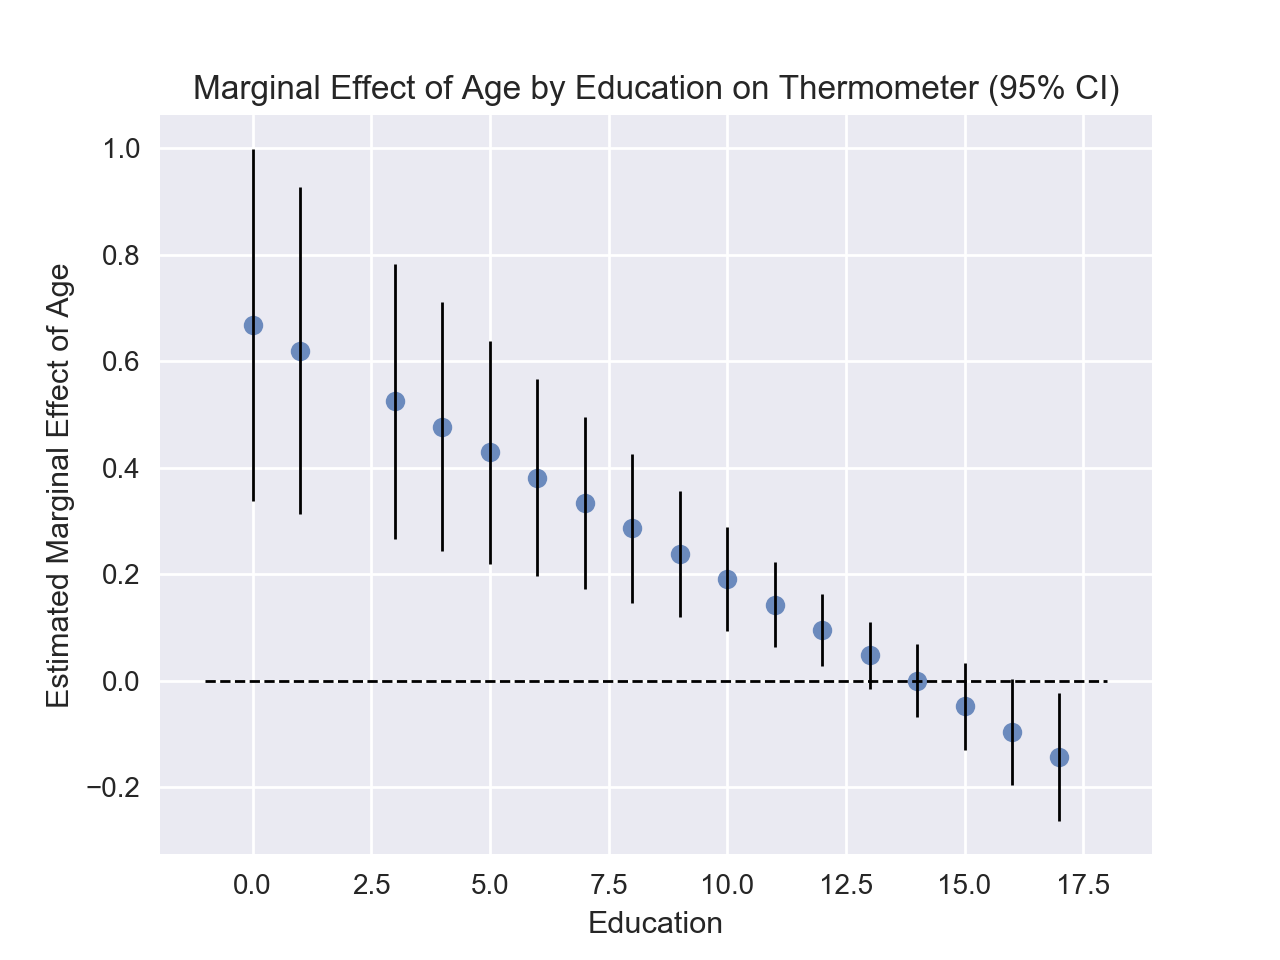

In [32]:
import seaborn as sns
sns.set()
df_age = pd.DataFrame()
df_age["X"] = biden["educ"].unique()
df_age["Y"] = b_1 + b_3 * df_age["X"]
df_age["SE"] = np.sqrt(var_covar_mat["age"]["age"] + 
                       df_age["X"] ** 2 * 
                       var_covar_mat["age_educ"]["age_educ"] + 
                       2 * df_age["X"] * var_covar_mat["age"]["age_educ"])
sns_plot = sns.regplot(x=df_age["X"], y=df_age["Y"], fit_reg=False)
for index, row in df_age.iterrows():
    sns_plot.vlines(x=row["X"], 
                     ymin=row["Y"] + 1.96 * row["SE"], 
                     ymax=row["Y"] - 1.96 * row["SE"], 
                     linewidth=1)
sns_plot.hlines(y=0,xmin=-1, xmax=18, linewidth=1, linestyles="dashed")
sns_plot.set(xlabel='Education', ylabel='Estimated Marginal Effect of Age', title="Marginal Effect of Age by Education on Thermometer (95% CI)");

<IPython.core.display.Javascript object>


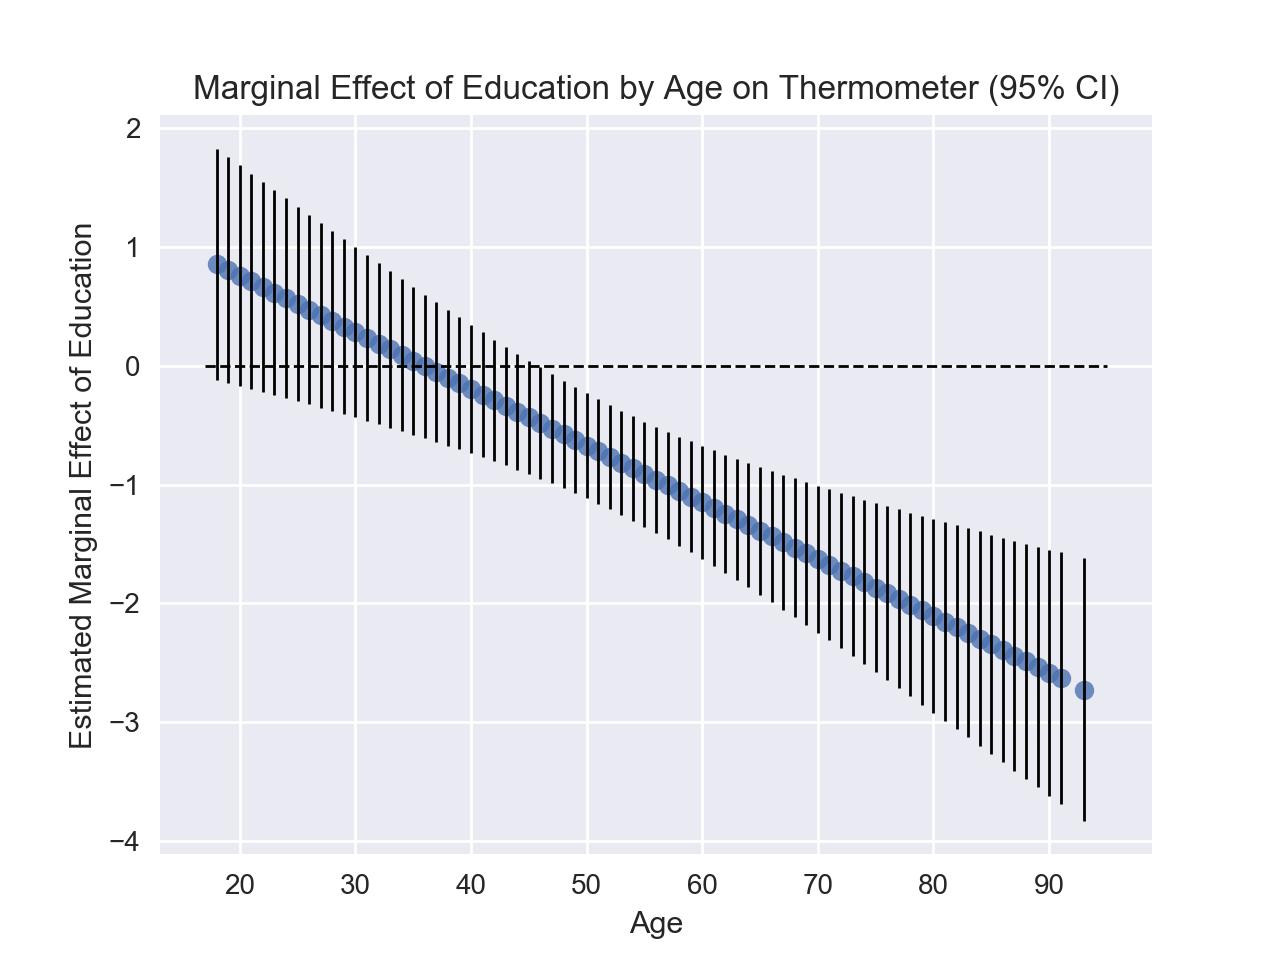

In [31]:
df_educ = pd.DataFrame()
df_educ["X"] = biden["age"].unique()
df_educ["Y"] = b_2 + b_3 * df_educ["X"]
df_educ["SE"] = np.sqrt(var_covar_mat["educ"]["educ"] + 
                       df_educ["X"] ** 2 * 
                       var_covar_mat["age_educ"]["age_educ"] + 
                       2 * df_educ["X"] * var_covar_mat["educ"]["age_educ"])
sns_plot = sns.regplot(x=df_educ["X"], y=df_educ["Y"], fit_reg=False)
for index, row in df_educ.iterrows():
    sns_plot.vlines(x=row["X"], 
                     ymin=row["Y"] + 1.96 * row["SE"], 
                     ymax=row["Y"] - 1.96 * row["SE"], 
                     linewidth=1)
sns_plot.hlines(y=0,xmin=17, xmax=95, linewidth=1, linestyles="dashed")
sns_plot.set(xlabel='Age', ylabel='Estimated Marginal Effect of Education', title="Marginal Effect of Education by Age on Thermometer (95% CI)");

<IPython.core.display.Javascript object>


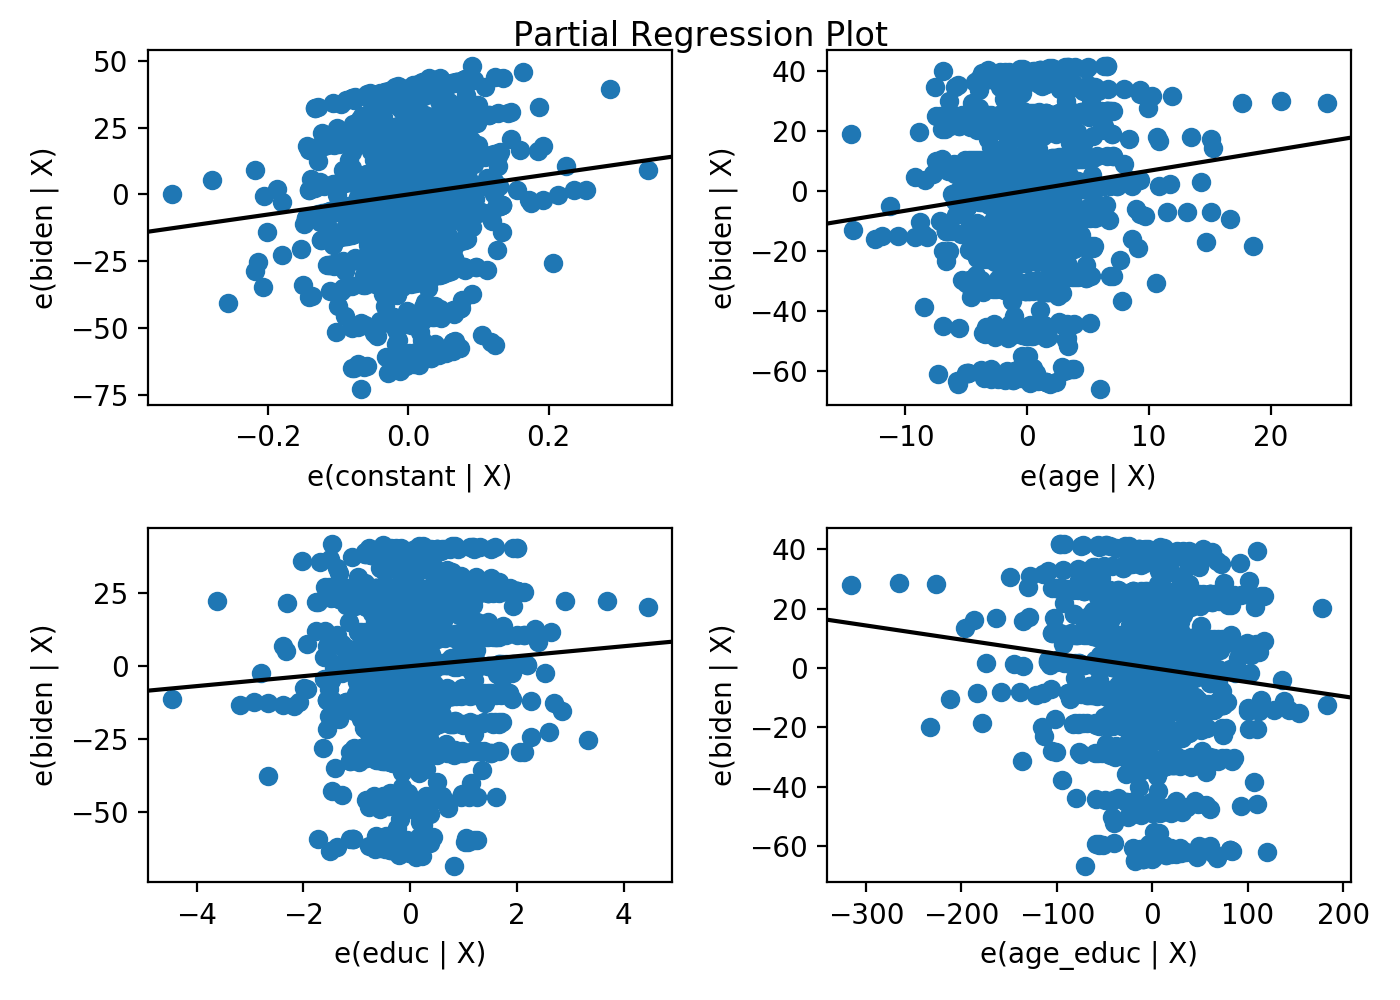

In [17]:
fig = plt.figure(figsize=(7,5))
#fig = sm.graphics.plot_regress_exog(model, "educ", fig=fig)
fig = sm.graphics.plot_partregress_grid(results, fig=fig)